# Аналитика в Яндекс.Афише

### Описание проекта:
Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.
У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
лог сервера с данными о посещениях сайта Яндекс.Афиши,
выгрузка всех заказов за этот период,
статистика рекламных расходов.

### Цель: 
Провести аналитику и выявить наиболее прибыльные и убыточные источники трафика и платформы. Составить рекомендацию для распределения затрат по источникам и платформам.

### Оглавление:
* [***1. Загрузка данных и подготовка их к анализу***](#first_step)
    * Датасет Visits
    * Датасет Orders
    * Датасет Costs
    * Проверка на дубликаты
    * Проверка логики 'revenue' <= 0
    * Проверка логики start_ts > end_ts
* [***2. Расчет метрик и построение отчетов***](#second_step)
    * [Продукт](#second_1_prestep)
        - Сколько людей пользуются в день, неделю, месяц?
        - Сколько сессий в день?
        - Сколько длится одна сессия?
        - Как часто люди возвращаются?
    * [Продажи](#second_2_prestep)
        - Когда люди начинают покупать?
        - Сколько раз покупают за период?
        - Какой средний чек?
        - Сколько денег приносят? (LTV)
    * [Маркетинг](#second_3_prestep)
        - Сколько денег потратили? Всего / на каждый источник / по времени
        - Сколько стоило привлечение одного покупателя из каждого источника?
        - На сколько окупились расходы? (ROI)
    * [Визуализация](#second_4_prestep)
* [***Вывод и рекомендации***](#third_step)

## 1. Загрузка данных и подготовка их к анализу <a class="anchor" id="first_step"></a>

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib
import datetime
matplotlib.style.use('fivethirtyeight')


In [2]:
#создание датафреймов
costs = pd.read_csv(r"C:\Users\dshf\Desktop\портфолио\Аналитика в Яндекс.Афише\data\costs.csv")
orders = pd.read_csv(r'C:\Users\dshf\Desktop\портфолио\Аналитика в Яндекс.Афише\data\orders_log.csv')
visits = pd.read_csv(r'C:\Users\dshf\Desktop\портфолио\Аналитика в Яндекс.Афише\data\visits_log.csv')

---

****Датасет Visits.****

---

In [3]:
#первые 5 строк таблицы
visits.head(5)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


_В данных visits нет пропусков, название столбцов неудобны и их лучше переименовать в названия с нижним регистром и без пробелов. Столбцы End Ts и Start Ts должны иметь тип datetime вместо текущего object. Необходимо это исправить._

In [5]:
#переименование столбцов
visits = visits.rename(columns={'Device':'device', 'End Ts':'end_ts', \
                                'Source Id':'source_id', 'Start Ts':'start_ts', 'Uid':'uid'})

In [6]:
#изменение типа данных столбцов end_ts и start_ts с object на datetime
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')

---

***Датасет Orders.***

---

In [7]:
orders.head(5)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


_В данных нет пропущенных значений и только один столбец имеет неправильный тип данных - Buy Ts. Его необходимо изменить с object на datetime и изменить названия столбцов._

In [9]:
orders = orders.rename(columns={'Buy Ts':'buy_ts', 'Revenue':'revenue', 'Uid':'uid'})

In [10]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

---
***Датасет Costs.***
___


In [11]:
costs.head(5)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [12]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


_В данных нет пропущенных значений и только один столбец имеет неправильный тип данных - dt. Его необходимо изменить с object на datetime и привести столбцы к нижнему регистру._

In [13]:
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


In [14]:
#приведение названий столбцов к нижнему регистру
costs.columns = costs.columns.str.lower()

In [15]:
costs['dt'] = pd.to_datetime(costs['dt'])

---
***Проверка на дубликаты***
___

In [16]:
#проверка датасета visits на предмет дубликатов со стартом в одно время
visits_dupl = visits[['device', 'source_id', 'start_ts', 'uid']].duplicated(keep=False)
visits_dupl[visits_dupl == True]

44993    True
47067    True
dtype: bool

In [17]:
#вывод строк по индексам
visits[(visits.index == 44993) | (visits.index == 47067)]

,device,end_ts,source_id,start_ts,uid
44993,touch,2018-03-16 08:57:00,1,2018-03-16 08:55:00,1981020429381477763
47067,touch,2018-03-16 08:55:00,1,2018-03-16 08:55:00,1981020429381477763


_Совпадают все столбцы кроме end_ts. Необходимо оставить только одну запись._

In [18]:
#удаление дубликтов
visits = visits.drop_duplicates(keep='first')
print('Кол-во дубликтов в датасете orders:', orders.duplicated(keep=False).sum())
print('Кол-во дубликтов в датасете costs:', costs.duplicated(keep=False).sum())

Кол-во дубликтов в датасете orders: 0
Кол-во дубликтов в датасете costs: 0


---
***Проверка логики 'revenue' <= 0***
___

In [19]:
print('Кол-во ордеров с нулевой стоимостью:', orders[orders['revenue'] <= 0]['revenue'].count())
print('Доля ордеров с нулевой стоимостью от общего кол-ва ордеров', round(orders[orders['revenue'] <= 0]\
      ['revenue'].count() / orders.shape[0], 3))

Кол-во ордеров с нулевой стоимостью: 51
Доля ордеров с нулевой стоимостью от общего кол-ва ордеров 0.001


In [20]:
#удаление ордеров с нулевым значением
orders = orders[orders['revenue'] > 0]

---
***Проверка логики start_ts > end_ts.***
___


In [21]:
#проверка логики start_ts > end_ts
diff = (visits['end_ts'] - visits['start_ts']).dt.seconds
print('Кол-во строк с условием diff<0:', (diff < 0).sum())

Кол-во строк с условием diff<0: 0


----

In [22]:
print('Уникальные источники из датасета visits:', visits['source_id'].unique())
print('Уникальные источники из датасета costs:', costs['source_id'].unique())

Уникальные источники из датасета visits: [ 4  2  5  9  3  1 10  7  6]
Уникальные источники из датасета costs: [ 1  2  3  4  5  9 10]


In [23]:
print('Кол-во посещенией по источникам:')
visits.device.value_counts()

Кол-во посещенией по источникам:


desktop    262567
touch       96833
Name: device, dtype: int64

## По итогам ##
**Предобработки данных:**

1. __В затратах наблюдаются не все источники трафика. Например, 6, 7, 8 отсутствуют. Это не позволит определить эффективность данных источников, так как нет информации по затратам на них.__
2. __В costs нет затрат в разбивке по платформам(desktop, touch).__
3. __Названия столбцов с пробелами и верхним регистром были заменены на нижнее подчеркивание и нижний регистр.__
4. __Некоторые столбцы имеющие дату, но с типом данных object приведены к типу 'datetime'.__
5. __Был найден 1 дубликат и удалены нулевые ордера.__
6. __Проведена проверка на присутствие в orders записей с нулевыми ордерами.__
7. __Проведена проверка на присутствие в visits записей, где время время окончания сессии больше времени начала сессии.__

## Шаг 2. Постройте отчёты и посчитайте метрики  <a class="anchor" id="second_step"></a>

### Продукт <a class="anchor" id="second_1_prestep"></a>

---
****Как часто люди возвращаются?****
___

In [24]:
#извлечение даты первого посещения из start_ts
visists_min = visits.groupby('uid')['start_ts'].min().reset_index()
visists_min['first_month'] = visists_min['start_ts'].astype('datetime64[M]')
visists_min = visists_min.drop(columns='start_ts')

In [25]:
#объединение с visits и извлечение месяца
visits_with_first = visits.merge(visists_min, on='uid')
visits_with_first['month'] = visits_with_first['start_ts'].astype('datetime64[M]')

In [26]:
#определение возраста когорты
visits_with_first['age'] = ((visits_with_first['month']  - visits_with_first['first_month']) / np.timedelta64(1, 'M'))\
.round().astype('int')

In [27]:
#группировка по первому месяцу и возврасту когороты с расчетом уникальных посетителей
cohorts_visits = visits_with_first.groupby(['first_month', 'age']).agg({'uid':'nunique'}).reset_index()
cohorts_visits.columns = ['first_month', 'age', 'cnt_visitors']

In [28]:
#churn rate
cohorts_visits['churn_rate'] = cohorts_visits.groupby('first_month')['cnt_visitors'].pct_change()

In [29]:
#retention rate
initial_users_count = cohorts_visits[cohorts_visits['age'] == 0][['first_month', 'cnt_visitors']]
initial_users_count.columns = ['first_month', 'cohort_visitors']
cohorts_visits = cohorts_visits.merge(initial_users_count, on='first_month')
cohorts_visits['retention_rate'] = cohorts_visits['cnt_visitors'] / cohorts_visits['cohort_visitors']

In [30]:
#сводная таблица retention rate
pivot_retention = cohorts_visits.pivot_table(index='first_month', columns = 'age', values='retention_rate')\
.fillna(0).drop(columns = 0)

In [31]:
#сводная таблица churn rate
pivot_churn = cohorts_visits.pivot_table(index='first_month', columns = 'age', values='churn_rate').fillna(0)

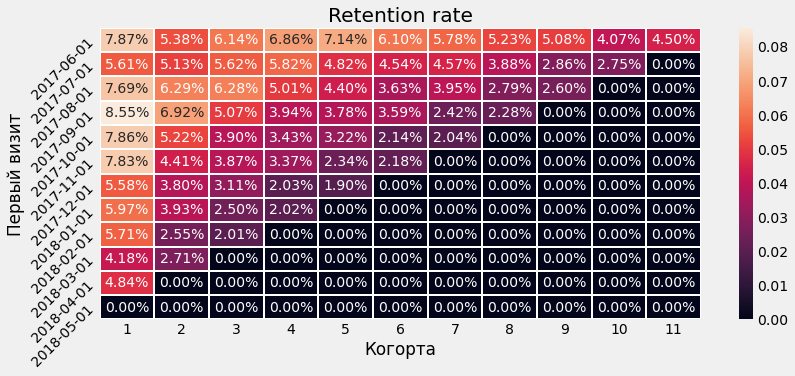

In [32]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.heatmap(pivot_retention, annot=True, linewidths=1, fmt='.2%')
ax.set_xlabel('Когорта')
ax.set_ylabel('Первый визит')
x_dates = pivot_retention.index.strftime('%Y-%m-%d').sort_values().unique()
ax.set_yticklabels(labels=x_dates, rotation=45, ha='right')
ax.set_title('Retention rate')
plt.show()

***Лучший показатель после первого месяца покупки это 2017-09, там остаются 9% клиентов с нулевого месяца покупки. В целом когорты с 2017-06 до 2017-11 удачны в первые месяцы жизни, а вот потом начинаются проблемы. Начиная с 2017-12 наблюдается сильный спад на возврат клиентов и с последующим ростом возраста когорты остаются 2-3%, что говорит о какой то проблеме с удержанием клиента, которая началась с 2017-11. Могу сделать предположение, что этот бизнес сезонный и летом данной услугой пользуются фанатики, а зимой приходят рядовые покупатели, которые уходят ближе к весне.***

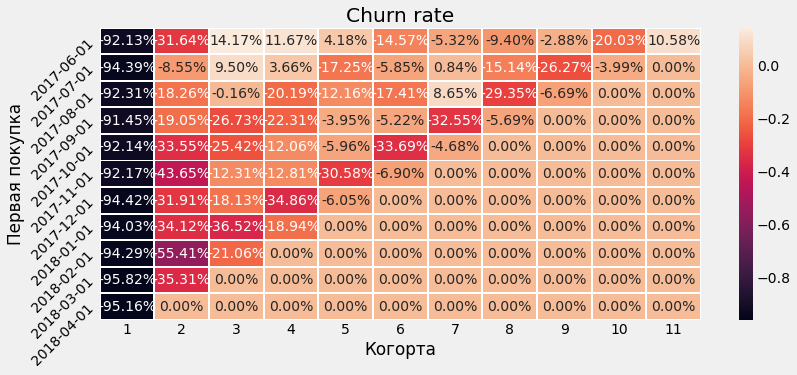

In [33]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.heatmap(pivot_churn, annot=True, linewidths=1, fmt='.2%')
ax.set_xlabel('Когорта')
ax.set_ylabel('Первая покупка')
x_dates = pivot_churn.index.strftime('%Y-%m-%d').sort_values().unique()
ax.set_yticklabels(labels=x_dates, rotation=45, ha='right')
ax.set_title('Churn rate')
plt.show()

***Картина похожая на предидущую. С 2017-06 по 2017-09  есть месяцы с приростом или с небольшим оттоком по когортам, но с приближением зимы процент оттока только растет.***

----
****Сколько сессий в день?****
___

In [34]:
#кол-во сессий в день
visits['per_day'] = visits['start_ts'].dt.date
visits_per_day = visits.groupby(['per_day']).agg({'uid':['nunique', 'count']}).reset_index()
visits_per_day.columns = ['per_day', 'cnt_clients', 'cnt_session']
visits_per_day['session_per_user'] = visits_per_day['cnt_session'] / visits_per_day['cnt_clients']

In [35]:
#извлечение месяца
visits_per_day['month'] = visits_per_day['per_day'].astype('datetime64[M]').dt.month

In [36]:
#извлечение года
visits_per_day['year'] = visits_per_day['per_day'].astype('datetime64[Y]').dt.year

In [37]:
#ун. кол-во пользователей и сессий помесячно
visits_month = visits_per_day.groupby('month').agg({'cnt_clients':'sum', 'cnt_session':'sum'}).reset_index()

In [38]:
print('Среднее кол-во сессий в день:', round(visits_per_day['cnt_session'].mean()))

Среднее кол-во сессий в день: 987


In [39]:
print('В среднем 1 пользователь сайта проводит на сайте сессий в месяц:', \
      round((visits_month['cnt_session'] / visits_month['cnt_clients']).mean(), 3))

В среднем 1 пользователь сайта проводит на сайте сессий в месяц: 1.085


In [40]:
print('В среднем 1 пользователь сайта проводит на сайте сессий в день:', \
      round(visits_per_day['session_per_user'].mean(), 3))

В среднем 1 пользователь сайта проводит на сайте сессий в день: 1.082


---
****Сколько людей пользуются в день, неделю, месяц?****
___

In [41]:
print('Количество людей в день', round(visits_per_day['cnt_clients'].mean()))

Количество людей в день 908


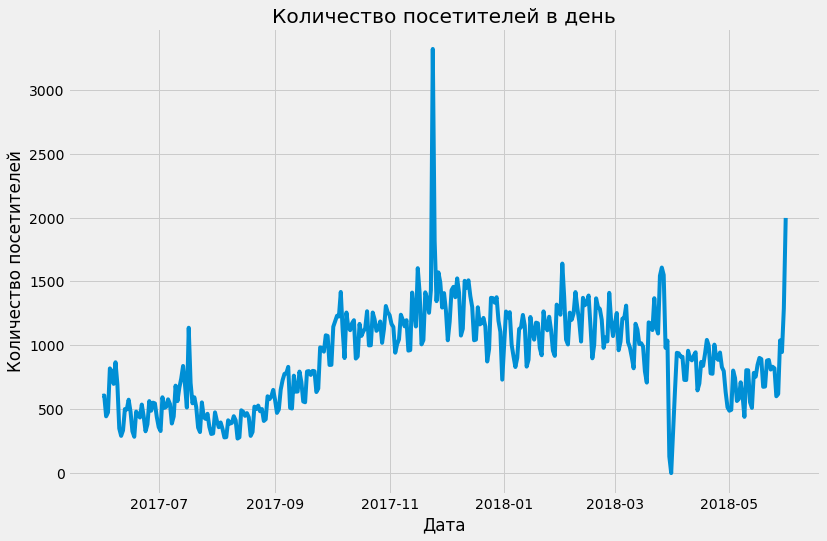

In [42]:
plt.figure(figsize=(12,8))
sns.lineplot(data = visits_per_day, x='per_day', y='cnt_clients')
plt.xlabel('Дата')
plt.ylabel('Количество посетителей')
plt.title('Количество посетителей в день')
plt.show()

In [43]:
print('Дата аномально высокого кол-ва посетителей', (visits_per_day[visits_per_day['cnt_clients'] > 3000]['per_day']))
print('Суммарные затраты на рекламу в этот день:', round(costs[costs['dt'] == '2017-11-24']['costs'].sum(), 1))

Дата аномально высокого кол-ва посетителей 176    2017-11-24
Name: per_day, dtype: object
Суммарные затраты на рекламу в этот день: 3458.9


In [44]:
print('Суммарные затраты за день до пика:', round(costs[costs['dt'] == '2017-11-23']['costs'].sum(), 1))

Суммарные затраты за день до пика: 1300.3


In [45]:
print('Дата аномально низкого кол-ва посетителей', (visits_per_day[visits_per_day['cnt_clients'] < 5]['per_day']))
print('Суммарные затраты на рекламу в день падения посетителей:', costs[costs['dt'] == '2018-03-31']['costs'].sum())

Дата аномально низкого кол-ва посетителей 303    2018-03-31
Name: per_day, dtype: object
Суммарные затраты на рекламу в день падения посетителей: 0.7


***На графике наблюдаются несколько аномальных всплесков. Первая выброс 2017-11-24 с количеством посетителей больше 3000 и  затратами 3458. Затраты в этот день значительно меньше чем в предидущий(1300), что и объясняет этот всплеск. Вложили больше денег в продвижение - получили больше посетителей. Похожая ситуация с аномально низким значением кол-ва посетителей 2018-03-31. В рекламу в этот аномально низкий день вложили очень мало(0.7) и получили наименьшее кол-во посетителей.***

In [46]:
#выделение года, недели, месяца
visits['per_year'] = visits['start_ts'].dt.year
visits['per_week'] = visits['start_ts'].dt.isocalendar().week
visits['per_month'] = visits['start_ts'].dt.month

In [47]:
#группировка по недели
visits_per_week = visits.groupby(['per_year', 'per_week']).agg({'uid':'nunique'}).reset_index()

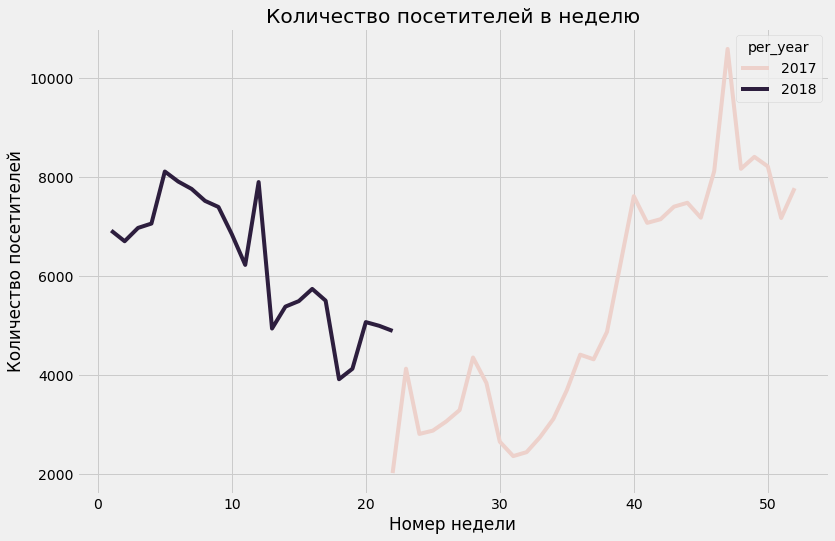

In [48]:
plt.figure(figsize=(12,8))
sns.lineplot(data = visits_per_week, x = 'per_week', y = 'uid', hue='per_year')
plt.xlabel('Номер недели')
plt.ylabel('Количество посетителей')
plt.title('Количество посетителей в неделю')
plt.show()


***Наблюдается глобальный рост с 35 недели года и глобальное падение с 12 недели года. Наивысшие показатели по кол-ву посетителей с 45 по 50 недели. Наименьшие показатели с 21 по 25 неделю.***

In [49]:
print('Среднее количество людей в неделю', round(visits_per_week['uid'].mean()))

Среднее количество людей в неделю 5716


In [50]:
#группировка по месяцу
visits_per_month = visits.groupby(['per_year', 'per_month']).agg({'uid':'nunique'}).reset_index()

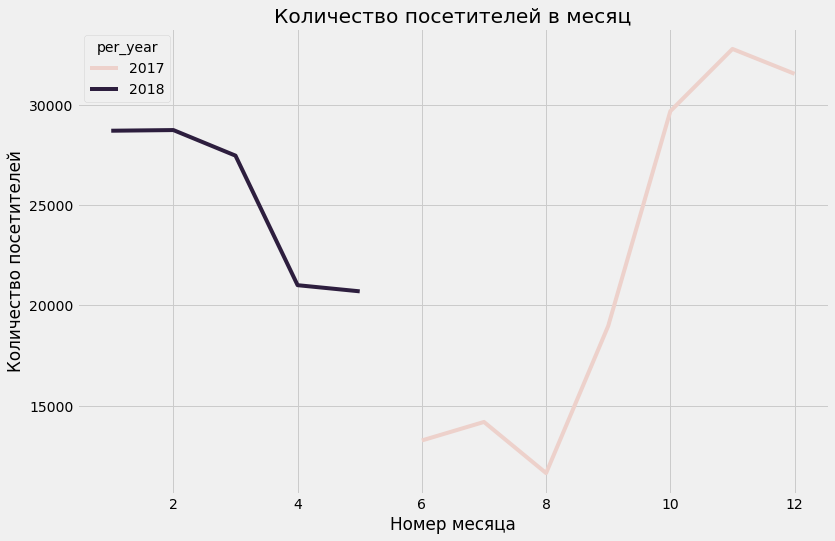

In [51]:
visits_per_month
plt.figure(figsize=(12,8))
sns.lineplot(data = visits_per_month, x = 'per_month', y = 'uid', hue='per_year')
plt.xlabel('Номер месяца')
plt.ylabel('Количество посетителей')
plt.title('Количество посетителей в месяц')
plt.show()


***На графике по месяцам видно, что с 9 месяца идет стабильный рост по посетителям и продолжается до 3 месяца. После 3 месяца кол-во посетителей начинает падать. Наивысшие показатели с 10 по 3 месяц. Наименьшие - с 6 по 8 месяцы. Вероятные причины  роста/падения- увеличение/уменьшение рекламного бюджета, сезонность продукта.***

In [52]:
print('Среднее количество людей в месяц', round(visits_per_month['uid'].mean()))

Среднее количество людей в месяц 23228


---
****Сколько длится одна сессия?****
___

In [53]:
#расчет длительности сессий
duration_sess = (visits['end_ts'] - visits['start_ts']).dt.seconds

<AxesSubplot:>

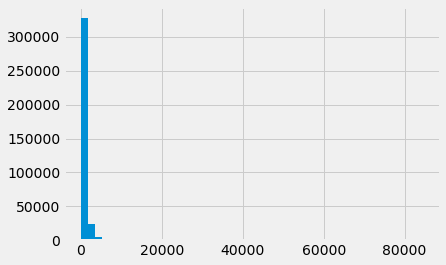

In [54]:
duration_sess.hist(bins=50)

*Из за большого кол-ва выбросов более целесообразно считать медиану или моду.*

In [55]:
print('Самое частовстречающееся значение', int(duration_sess.mode()))
print('Медиана', int(duration_sess.median()))

Самое частовстречающееся значение 60
Медиана 300


### Продажи <a class="anchor" id="second_2_prestep"></a>

---
****Когда люди начинают покупать?****
___

In [56]:
#дата первого посещения и первой покупки каждого посетителя
full_first_visit = visits.groupby('uid')['start_ts'].min().reset_index()
first_order_date = orders.groupby('uid')['buy_ts'].min().reset_index()
orders_with_first_vis = first_order_date.merge(full_first_visit, on='uid')

In [57]:
#дельта даты покупки и даты первого посещения
orders_with_first_vis['delta_order'] = (orders_with_first_vis['buy_ts'] - orders_with_first_vis['start_ts']).dt.seconds

<AxesSubplot:>

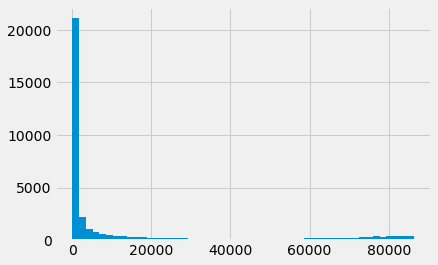

In [58]:
orders_with_first_vis['delta_order'].hist(bins=50)

*Огромное кол-во выбросов. Расчет по моде или медиане.*

In [59]:
print('Самое частовстречаемое значение:', int(orders_with_first_vis['delta_order'].mode()))

Самое частовстречаемое значение: 60


In [60]:
print('Медианное значение в минутах:', (orders_with_first_vis['delta_order'].median()) / 60)

Медианное значение в минутах: 16.0


---
****Сколько раз покупают за период?****
___

In [61]:
#кол-во покупок по месяцам
with_first_vis = full_first_visit.merge(orders, on='uid')
with_first_vis['date_buy'] = with_first_vis['buy_ts'].astype('datetime64[M]')
cnt_per_month = with_first_vis.groupby('date_buy').agg({'uid':['nunique', 'count']}).reset_index()
cnt_per_month['date_buy'] = cnt_per_month['date_buy'].dt.to_period('M')

<Figure size 648x504 with 0 Axes>

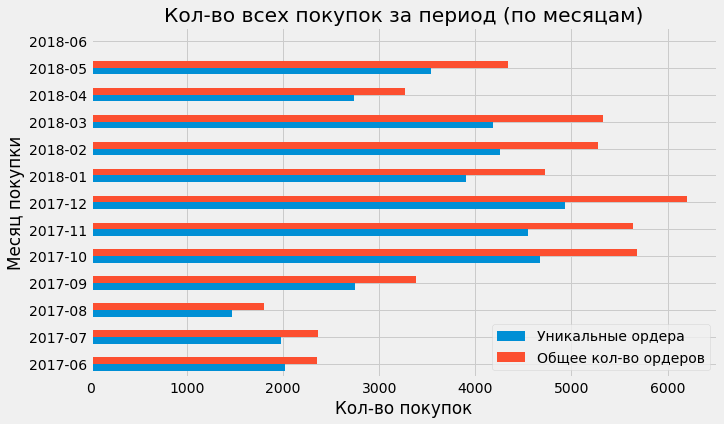

In [62]:
plt.figure(figsize=(9,7))
cnt_per_month.plot.barh(x='date_buy', y='uid', grid=True, rot=0, figsize=(10,6))
plt.ylabel('Месяц покупки')
plt.xlabel('Кол-во покупок')
plt.title('Кол-во всех покупок за период (по месяцам)')
plt.legend(['Уникальные ордера', 'Общее кол-во ордеров'])
plt.show()

***Основное кол-во покупок приходится на период с 2017-10 по 2018-03. Максимальное число покупок произошло 2017-12, а с 2018-01 виден значительный спад. Скорее всего причина появления такой картины - это Новый Год. Люди покупают подарки и видно, что некоторые начинают этим заниматься уже с октября и пик приходится на декабрь. В январе же резкое падения, так как люди сидят дома и основные средства были потрачены на подарки в декабре. Абсолютный аутсайдер по продажам это 2017-08, здесь антирекорд и скорее всего Афиша возможно имеет сезонность. Летом люди стараются быть на природе, зимой в помещении(к примеру театр, кинотеатр и тд) поэтому продаж зимой больше.***

---
****Какой средний чек?****
___

In [63]:
print('Средний чек:', round(orders['revenue'].mean(), 3))

Средний чек: 5.005


In [64]:
print('Средний доход с каждого уникального посетителя сайта (ARPU):', \
      round((orders['revenue'].mean() * orders.shape[0]) / visits['uid'].nunique(), 3))

Средний доход с каждого уникального посетителя сайта (ARPU): 1.105


In [65]:
print('Средний доход с каждого уникального покупателя (ARPPU):',\
      round((orders['revenue'].mean() * orders.shape[0]) / orders['uid'].nunique(), 3))

Средний доход с каждого уникального покупателя (ARPPU): 6.904


---
****Сколько денег приносят?****
___

In [66]:
#определение размера когорт
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
first_date_orders = orders.groupby('uid')['order_month'].min()\
.reset_index().rename(columns={'order_month':'first_order_month'})
cohort_sizes = first_date_orders.groupby('first_order_month')['uid'].nunique()\
.reset_index().rename(columns={'uid':'n_buyers'})

In [67]:
#соединение orders с датасетом ордеров с первой датой покупки
orders_with_first = orders.merge(first_date_orders, on='uid')

In [68]:
#определение возраста когорты
cohorts = orders_with_first.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum'}).reset_index()
cohorts['age'] = (cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1, 'M')
cohorts['age'] = cohorts['age'].round().astype('int')

In [69]:
report = pd.merge(cohorts, cohort_sizes, on='first_order_month')

In [70]:
#расчет ltv
report['ltv'] = report['revenue'] / report['n_buyers']
report_ltv_piv = report.pivot_table(index='first_order_month', columns ='age', values='ltv')
report_ltv_piv = report_ltv_piv.cumsum(axis=1).round(2).fillna(0)
report_ltv_piv.index = report_ltv_piv.index.strftime('%Y-%m')
report_ltv_piv.loc['mean'] = report_ltv_piv.mean()

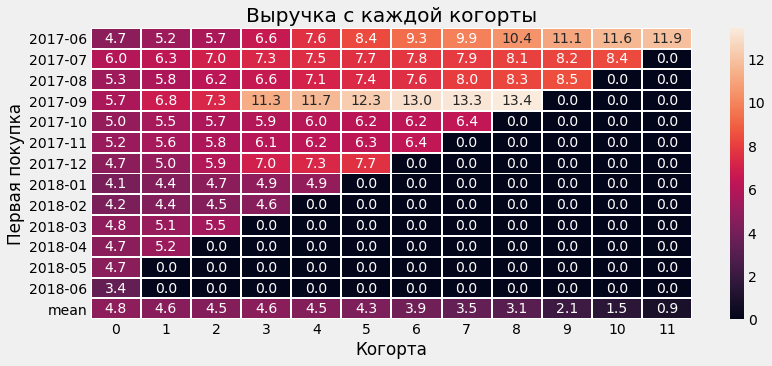

In [71]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.heatmap(report_ltv_piv, annot=True, linewidths=1, fmt='.1f')
ax.set_xlabel('Когорта')
ax.set_ylabel('Первая покупка')
ax.set_title('Выручка с каждой когорты')
plt.show()

***Доходность в первый месяц покупки находится примерно на одном уровне (~5). Хорошие результаты показывают когорты где первый ордер был 2017-06, 2017-07, 2017-08, 2017-09 (выдающаяся накопитульная сумма), но эти когорты старые. Что касается новых, то это люди, с первыми ордерами 2017-12 имеют хорошую доходность. Когорты с первым ордером 2018-01 и 2018-02 самые менеедоходные. ***

### Маркетинг <a class="anchor" id="second_3_prestep"></a>

---
****Сколько денег потратили? Всего / на каждый источник / по времени****
___

In [72]:
print('Общая сумма затрат:', costs['costs'].sum())

Общая сумма затрат: 329131.62


In [73]:
#группировка затрат по источникам
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()

<Figure size 432x288 with 0 Axes>

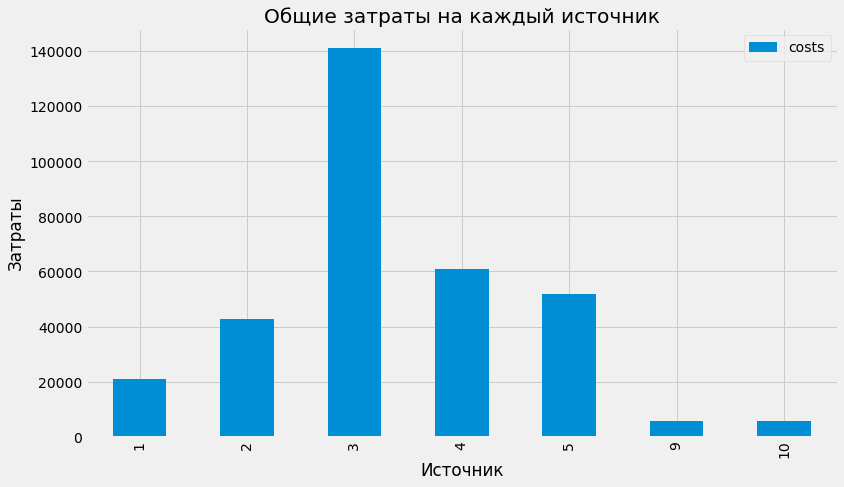

In [74]:
plt.figure()
costs_by_source.plot(kind='bar', x='source_id', y='costs', figsize=(12,7))
plt.xlabel('Источник')
plt.ylabel('Затраты')
plt.title('Общие затраты на каждый источник')
plt.show()



***На графике видно явное доминирование 3 источника трафика со значением больше 140000. Так же на 2 и 3 месте находятся источники под номерами 4 и 5 с примерно одинаковым бюджетом в 50000-60000. Оправдано ли это распределение или может стоило отдавать приоритет другим источникам? Это будет известно далее.***

---
****Сколько стоило привлечение одного покупателя из каждого источника?****
___

In [75]:
#расчет общих затрат и помесячных затрат по источникам
costs_date = costs.copy()
costs_date['month'] = costs_date['dt'].astype('datetime64[M]')
costs_months = costs_date.groupby('month')['costs'].sum().reset_index()
costs_months['month'] = costs_months['month'].dt.to_period('M')

In [76]:
diff_costs = costs_date.groupby(['month', 'source_id'])['costs'].sum().reset_index()

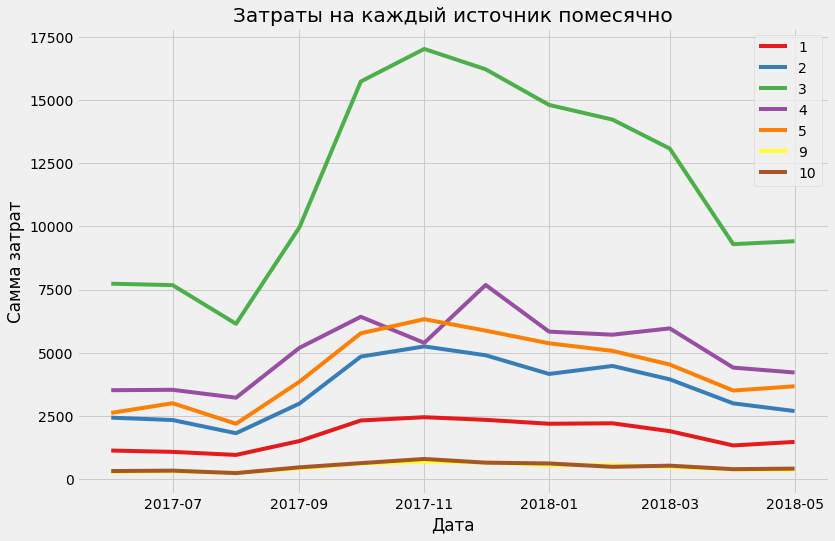

In [77]:
plt.figure(figsize=(12,8))
sns.lineplot(data = diff_costs, x='month', y='costs', hue='source_id', legend=False, palette = 'Set1')
plt.xlabel('Дата')
plt.ylabel('Самма затрат')
plt.title('Затраты на каждый источник помесячно')
plt.legend(diff_costs['source_id'])
plt.show()

***На графике видно глобальное увеличение затрат с 2017-09, а с 2018-03 наблюдается тренд падения. Абсолютный лидер по затратам это 3 источник. 4ый, 5ый и 2ой имеют примерно одинаковые затраты на всем протяжении. У первого истоничка затраты ниже среднего. У 9го и 10го затраты самые минимальные.***

<Figure size 432x288 with 0 Axes>

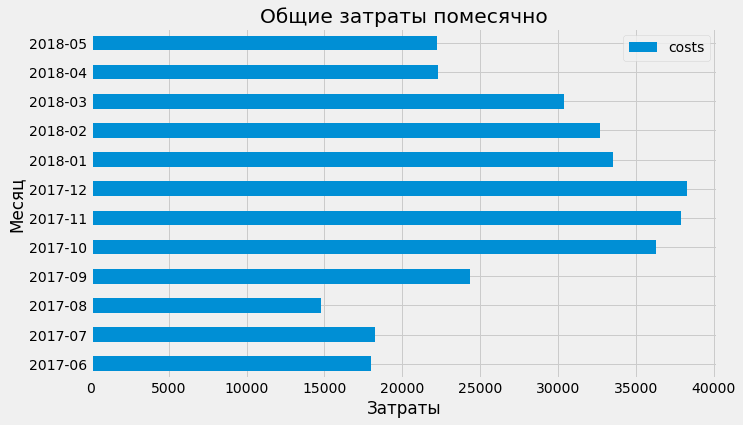

In [78]:
plt.figure()
costs_months.plot(x ='month', y= 'costs', kind='barh', figsize=(10,6))
plt.ylabel('Месяц')
plt.xlabel('Затраты')
plt.title('Общие затраты помесячно')
plt.show()

***График очень похож на график кол-ва ордеров по месяцам. Вывод двольно очевидный, чем больше вкладываем в рекламу, тем больше получаем выручку, но остается узнать эффективность вложений в рекламу.***

---
****На сколько окупились расходы? (ROI)****
___

In [79]:
#первая покупка клиента с источником
sources = visits.sort_values(by=['uid', 'start_ts']).groupby('uid').agg({'source_id':'first'})
orders_with_sources = orders.groupby('uid').agg({'order_month':'min'})\
.merge(sources, on='uid').reset_index().rename(columns={'order_month':'first_order_month'})

In [80]:
#ltv
ltv = pd.merge(orders_with_sources, orders, on='uid')
ltv['age'] = (ltv['order_month'] - ltv['first_order_month']) / np.timedelta64(1, 'M')
ltv['age'] = ltv['age'].round().astype('int')

In [81]:
#кол-во ордеров
cnt_orders = ltv.pivot_table(index='source_id', columns='age', values='revenue', aggfunc='count').fillna(0)

In [82]:
#кол-во покупателей
cnt_buyers = ltv.pivot_table(index='source_id', columns='age', values='uid', aggfunc='nunique').fillna(0)

In [83]:
ltv = ltv.pivot_table(index='source_id', columns='age', values='revenue', aggfunc='sum').fillna(0)
ltv = ltv.cumsum(axis=1)

In [84]:
#размеры когорт по источникам
sources_cohort_size = orders_with_sources.groupby(['source_id']).agg({'uid':'nunique'}).reset_index()\
.rename(columns = {'uid': 'cohort_size'})

In [85]:
#расчет ltv
ltv = ltv.merge(sources_cohort_size, on='source_id').set_index('source_id')
ltv = ltv.div(ltv['cohort_size'], axis=0).drop(columns='cohort_size').reset_index()

In [86]:
#расчет cac
cac = costs.groupby('source_id').agg({'costs':'sum'}).reset_index().merge(sources_cohort_size, on='source_id')
cac['cac'] = cac['costs'] / cac['cohort_size']
cac = cac.drop(columns=['costs', 'cohort_size'])

In [87]:
#расчет ROI
roi = ltv.merge(cac, on='source_id').set_index('source_id')
roi = roi.div(roi['cac'], axis=0).drop(columns='cac')

### Визуализация <a class="anchor" id="second_4_prestep"></a>

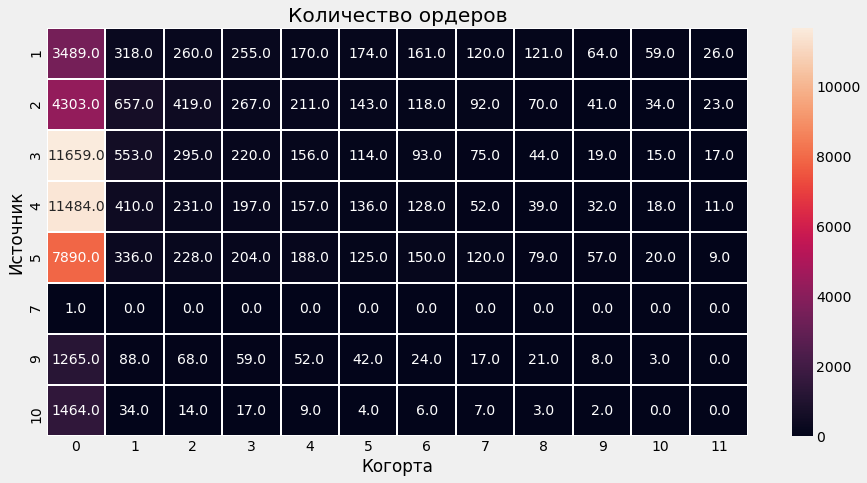

In [88]:
plt.figure(figsize=(14,7))
sns.heatmap(cnt_orders, annot=True, linewidths=1, fmt='.1f')
plt.xlabel('Когорта')
plt.ylabel('Источник')
plt.title('Количество ордеров')
plt.show()


***Сразу стоит отметить, что по источнику 7 делать какие то выводы не имеет смысла, тк 1 заказ - это очень мало для анализа. Наибольшее кол-во заказов наблюдается у источников 3, 4, 5. На них стоит обратить особое внимаение, тк необходимо понять, отбили ли мы деньги на рекламу с этих источников данными заказами. Источники 1, 2, 9, 10 имеют достаточное кол-во заказов для анализа.***

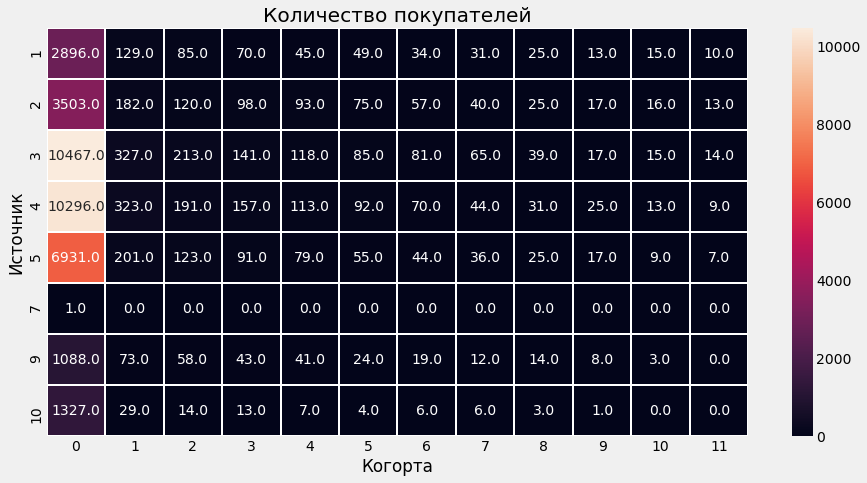

In [89]:
plt.figure(figsize=(14,7))
sns.heatmap(cnt_buyers, annot=True, linewidths=1, fmt='.1f')
plt.xlabel('Когорта')
plt.ylabel('Источник')
plt.title('Количество покупателей')
plt.show()


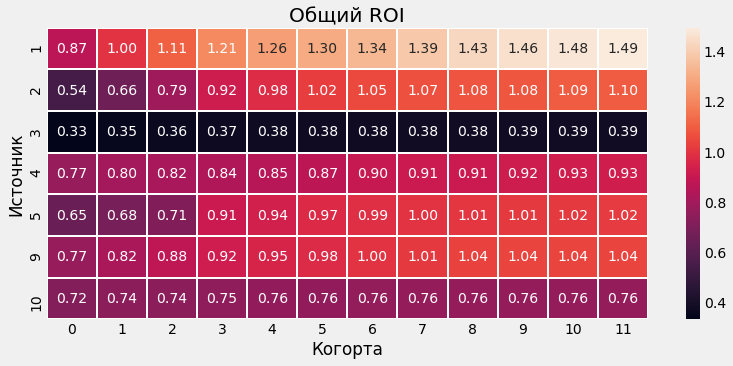

In [90]:
plt.figure(figsize=(12,5))
sns.heatmap(roi, annot=True, linewidths=1, fmt='.2f')
plt.xlabel('Когорта')
plt.ylabel('Источник')
plt.title('Общий ROI')
plt.show()

***Общий ROI выделяет 1ый, 2ой источники, как самые прибыльные. Абсолютный фаворит по прибыле - 1ый источник. Абсолютный аутсайдер это - 3 источник, на который было потрачено самое большое кол-во средств, а по факту, с ним бы стоило распрощаться, или оставить какой мизирный процент затрат на него. Есть средние показатели и это источник 5 и 9. С ними не будет особой прибыли, но и за 12 месяцев не уйдешь в убыток. Так же можно увидеть, что если нам надо отбивать затраты максимально быстро, то надо увеличивать затраты на 1 источник, тк уже на 2ой месяц мы отбиваем затраты. Итог: лучше источники по прибыле по общей картине - 1, 2. Источники 5,9 не дадут большой прибыли за 12 мес, но и не покажут убыток. С источником 4 спорный вопрос, он не показывает прибыли за 12 мес, но на первом месяце показывает 0.77 возврата от расходов и 0.93 через 12 мес. Ну и источники, которые стоило бы отключить(по моему мнению) это - 3, 10.***

## Вывод <a class="anchor" id="third_step"></a>

В ходе работы были изучены и проанализированы данные о посетителях, покупателях и затрат сервиса Яндекс.Афиша. Так же в ходе исследования данных были выявлены неправильные типы данных в колонках, найден дубликат и нулевые ордера. Данные неточности были исправлены и на их основе произведен анализ, по итогам которого были составлены некоторые рекомендации для отдела маркетинга по затратам на рекламу.

Общий ROI выделяет 1ый, 2ой источники, как самые прибыльные. Абсолютный фаворит по прибыли - 1ый источник. Абсолютный аутсайдер это - 3 источник, на который было потрачено самое большое кол-во средств. Есть средние показатели и это источник 5 и 9. С ними не будет особой прибыли, но и за 12 месяцев не уйти в убыток. Так же можно увидеть, что если цуль отбивать затраты максимально быстро, то надо увеличивать затраты на 1ый источник, так как уже на 2ой месяц затраты окупаются.

Так же наблюдается сезонность бизнеса. Летом число посетителей меньше, ближе к зиме возрастает, так же как и затраты на рекламу.

И далее результаты анализа уже всех графиков.

* ***1ый источник*** - самый перспективный. На него стоит обратить внимание. **30% от общего бюджета**


* ***2ой источник*** - в принципе, он так же хорош, как и первый источник, но чуть ему успает по стабильности. **20% от общего бюджета**


* ***3ый источник*** - либо вообще отказаться от него, либо оставить на него самый минимальный бюджет. **5% от общего бюджета**


* ***4ый источник*** - особой прибыли в течениии года от него не стоит ждать. Претендент на отключение после 3го источника **13% от общего бюджета**


* ***5ый источник*** - на глобальной картине он себя отбивает, но имеет очень низкий доход. **10% от общего бюджета**


* ***9ый источник*** - хорошая доходность в 0 когорте, но в следующих когортах не намного лучше 5го источника. **17% от общего бюджета**


* ***10ый источник*** - тоже аутсайдер от которого я бы отказался. **5% от общего бюджета**


Причины, по которым я бы оставил низкодоходные источники это - возможно какие то из них будут привлекать мобильный трафик, который на данный момент стабильно растет и начинает вытеснять компьютерный трафик.
